Import Libraries & Data

In [1]:
# Import Libraries & Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, recall_score

data = pd.read_csv('Features.csv')

Create a Function for the Random Forest Model

In [2]:
# Define a Function for Random Forest Model
def RFC_model(train, test, predictor_list):
    RFC = RandomForestClassifier(n_estimators = 100, random_state = 1, min_samples_split = 10)
    RFC.fit(train[predictor_list], train["Output"])
    predictions = RFC.predict(test[predictor_list])

    acc_score = accuracy_score(test["Output"], predictions)
    return print("Accuracy: {:.2f}%".format(acc_score*100))

In [3]:
# Train Model on 2020/2021 Season to Predict 2021/2022 Season - Basic Predictors
basic_predictors = ["Home Team", "Away Team", "Hour", "Day of Week", "Month"]
training_set = data[data["Season"] == '20_21']
test_set = data[data["Season"] == '21_22']
RFC_model(training_set, test_set, basic_predictors)

Accuracy: 55.14%


In [4]:
# Train Model on Two Previous Seasons to Predict 2021/2022 Season - Basic Predictors
values = ['19_20', '20_21']
training_set = data[data["Season"].isin(values)]
test_set = data[data["Season"] == '21_22']
RFC_model(training_set, test_set, basic_predictors)

Accuracy: 59.71%


In [5]:
# Add Extra Predictors
predictors = list(data.columns[4:66])
predictors.remove('Season')
training_set = data[data["Season"].isin(values)]
test_set = data[data["Season"] == '21_22']
RFC_model(training_set, test_set, predictors)

Accuracy: 62.57%


In [6]:
# Add In Data from Current Season for Training Set
training_set = data[data["Date"] < '2022-01-01']
test_set = data[data["Season"] == '21_22']
test_set = test_set[test_set["Date"] >= '2022-01-01']
RFC_model(training_set, test_set, predictors)

Accuracy: 63.45%


Optimize with Grid Search

In [7]:
# Optimize Model Using Custom Grid Search
from sklearn.model_selection import ParameterGrid
RF_Classifier = RandomForestClassifier()
p_grid = ParameterGrid({"n_estimators": [90, 100, 110, 120],
                        "random_state": [1],
                        "min_samples_split": [7, 10],
                        "max_samples": [10, 20, 30]})

# Loop Through Parameter Grid
accuracies = []
combinations = []
for p in p_grid:
    RF_Classifier.set_params(**p)
    RF_Classifier.fit(training_set[predictors], training_set["Output"])
    predictions = RF_Classifier.predict(test_set[predictors])

    acc_score = accuracy_score(test_set["Output"], predictions)
    prec_score = precision_score(test_set["Output"], predictions)
    recall = recall_score(test_set["Output"], predictions)
    cf = confusion_matrix(test_set["Output"], predictions)
    accuracies.append(acc_score)
    combinations.append(p)
    
max_score = max(accuracies)
score_index = accuracies.index(max_score)
op_combination = combinations[score_index]
print("Best Parameters: ", op_combination)
print("Accuracy: {:.2f}%".format(max_score*100))

Best Parameters:  {'max_samples': 20, 'min_samples_split': 10, 'n_estimators': 110, 'random_state': 1}
Accuracy: 65.48%


In [8]:
# Check Other Accuracy Metrics with Optimized Model
RF_check = RandomForestClassifier()
RF_check.set_params(**op_combination)
RF_check.fit(training_set[predictors], training_set["Output"])
predictions = RF_check.predict(test_set[predictors])

acc_check = accuracy_score(test_set["Output"], predictions)
prec_check = precision_score(test_set["Output"], predictions)
recall_check = recall_score(test_set["Output"], predictions)
cf = confusion_matrix(test_set["Output"], predictions)

print("Accuracy: {:.2f}%".format(acc_check*100))
print("Precision: {:.2f}%".format(prec_check*100))
print("Recall: {:.2f}%".format(recall_check*100))
print(cf)

Accuracy: 65.48%
Precision: 66.07%
Recall: 43.02%
[[92 19]
 [49 37]]


Feature Importance

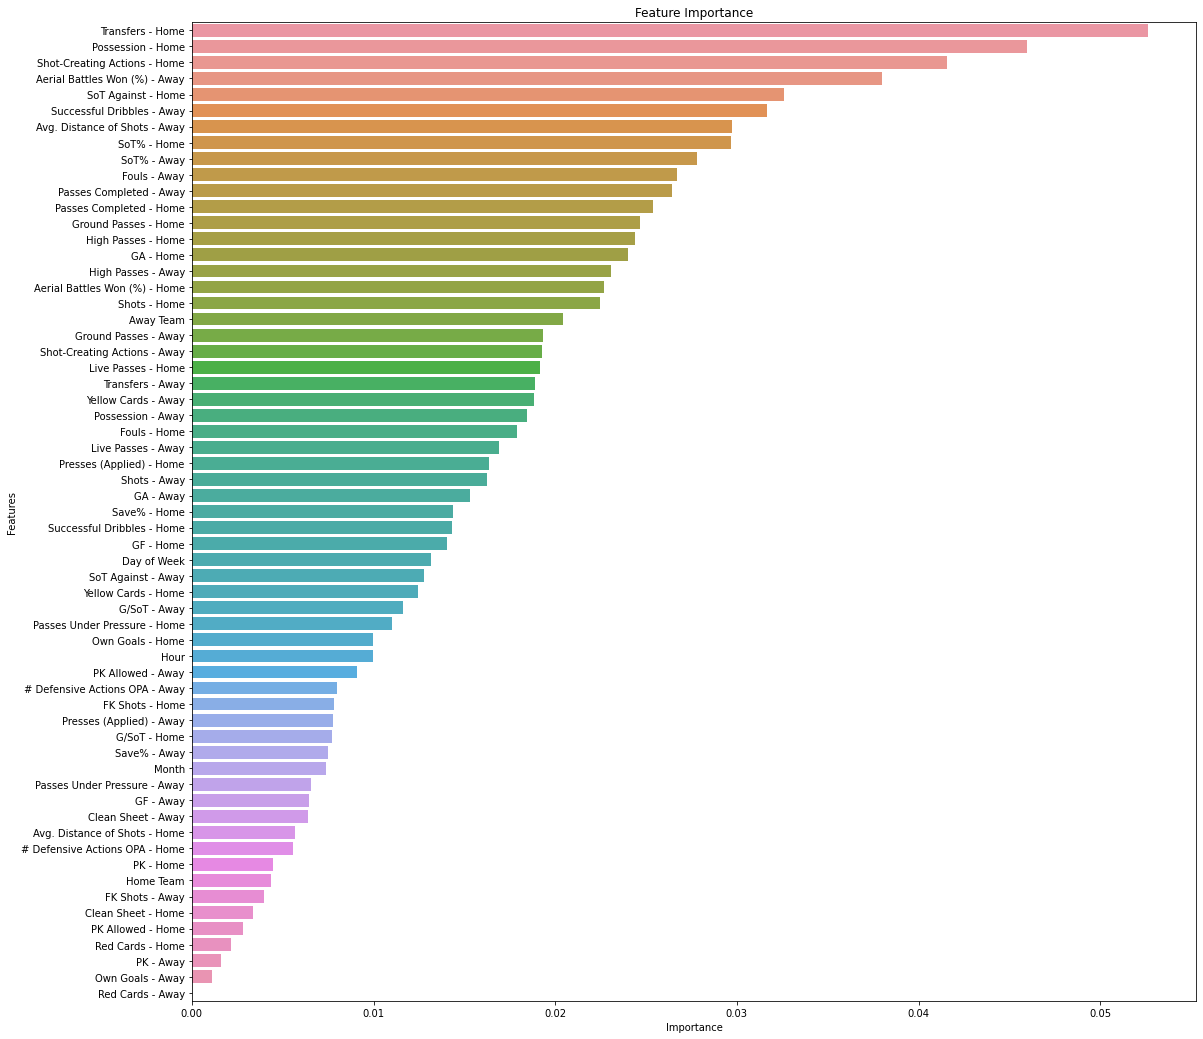

In [15]:
# Feature Importance
feature_importance = pd.DataFrame(RF_Classifier.feature_importances_, index = predictors, columns=['Importance']).sort_values('Importance', ascending=False) 
plt.figure(figsize = (18, 18))
sns.barplot(y = feature_importance.index, x = feature_importance["Importance"])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig('feature_importance.jpg')

Modelling 2022/2023 Season

In [10]:
# Run Model on 2022/2023 Season
training_set = data[data["Date"] < '2022-08-27']
test_set = data[data["Date"] >= '2022-08-27']

RF_ = RandomForestClassifier()
RF_.set_params(**op_combination)
RF_.fit(training_set[predictors], training_set["Output"])
predictions = RF_.predict(test_set[predictors])

acc_check = accuracy_score(test_set["Output"], predictions)
prec_check = precision_score(test_set["Output"], predictions)
recall_check = recall_score(test_set["Output"], predictions)
cf = confusion_matrix(test_set["Output"], predictions)

print("Accuracy: {:.2f}%".format(acc_check*100))
print("Precision: {:.2f}%".format(prec_check*100))
print("Recall: {:.2f}%".format(recall_check*100))
print(cf)

Accuracy: 70.27%
Precision: 90.00%
Recall: 47.37%
[[17  1]
 [10  9]]


XGBoost

In [12]:
# Try XGBoost Model
from sklearn.ensemble import GradientBoostingClassifier
XGB = GradientBoostingClassifier()

# Optimize Model Using Custom Grid Search
p_grid = ParameterGrid({"loss": ['log_loss', 'exponential'],
                        "n_estimators": [80, 90, 100, 110, 120],
                        "random_state": [1],
                        "min_samples_split": [3, 5, 7, 10],
                        "learning_rate": [0.1, 0.2, 0.3]})

# Loop Through Parameter Grid
accuracies = []
combinations = []
for p in p_grid:
    XGB.set_params(**p)
    XGB.fit(training_set[predictors], training_set["Output"])
    predictions = XGB.predict(test_set[predictors])

    acc_score = accuracy_score(test_set["Output"], predictions)
    prec_score = precision_score(test_set["Output"], predictions)
    recall = recall_score(test_set["Output"], predictions)
    cf = confusion_matrix(test_set["Output"], predictions)
    accuracies.append(acc_score)
    combinations.append(p)
    
max_score = max(accuracies)
score_index = accuracies.index(max_score)
op_combination = combinations[score_index]
print("Best Parameters: ", op_combination)
print("Accuracy: {:.2f}%".format(max_score*100))

Best Parameters:  {'learning_rate': 0.2, 'loss': 'exponential', 'min_samples_split': 5, 'n_estimators': 120, 'random_state': 1}
Accuracy: 72.97%


In [13]:
# Check Other Accuracy Metrics with Optimized Model
xgb_check = GradientBoostingClassifier()
xgb_check.set_params(**op_combination)
xgb_check.fit(training_set[predictors], training_set["Output"])
predictions = xgb_check.predict(test_set[predictors])

acc_check = accuracy_score(test_set["Output"], predictions)
prec_check = precision_score(test_set["Output"], predictions)
recall_check = recall_score(test_set["Output"], predictions)
cf = confusion_matrix(test_set["Output"], predictions)

print("Accuracy: {:.2f}%".format(acc_check*100))
print("Precision: {:.2f}%".format(prec_check*100))
print("Recall: {:.2f}%".format(recall_check*100))
print(cf)

Accuracy: 72.97%
Precision: 71.43%
Recall: 78.95%
[[12  6]
 [ 4 15]]
